In [1]:
#to disable isaac startup logs
import sys
import signal

from isaacsim import SimulationApp

CONFIG = {
    'headless': False,
    'display_options': 3286
}

simulation_app = SimulationApp(CONFIG)
simulation_app.update()

spinning = True
def sigint_handler(sig, frame):
    global spinning
    spinning = False
signal.signal(signal.SIGINT, sigint_handler)

kernel = get_ipython().kernel
kernel.pre_handler_hook = lambda: None
kernel.post_handler_hook = lambda: None

def spin(update_function, *args, **kwargs):
    global spinning
    print('gui can be used now. interrupt kernel to go back to notebook')
    while spinning:
        update_function(*args, **kwargs)
    spinning = True

def resume_gui():
    spin(lambda: simulation_app.update())

Starting kit application with the following args:  ['/f/ov/pkg/isaac-sim-4.1.0/exts/omni.isaac.kit/omni/isaac/kit/simulation_app.py', '/f/ov/pkg/isaac-sim-4.1.0/apps/omni.isaac.sim.python.kit', '--/app/tokens/exe-path=/f/ov/pkg/isaac-sim-4.1.0/kit', '--/persistent/app/viewport/displayOptions=3286', '--/rtx/materialDb/syncLoads=True', '--/rtx/hydra/materialSyncLoads=True', '--/omni.kit.plugin/syncUsdLoads=True', '--/app/renderer/resolution/width=1280', '--/app/renderer/resolution/height=720', '--/app/window/width=1440', '--/app/window/height=900', '--/renderer/multiGpu/enabled=True', '--/app/fastShutdown=False', '--ext-folder', '/f/ov/pkg/isaac-sim-4.1.0/exts', '--ext-folder', '/f/ov/pkg/isaac-sim-4.1.0/apps', '--/physics/cudaDevice=0', '--portable']
Passing the following args to the base kit application:  ['-f', '/home/linh/.local/share/jupyter/runtime/kernel-946d573d-8eb7-4e77-a000-6e2aa1eb0f8f.json']
[Warning] [omni.isaac.kit.simulation_app] Non-headless mode not supported with jupyt

Warp 1.2.1 initialized:
   CUDA Toolkit 11.8, Driver 12.5
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 4060" (8 GiB, sm_89, mempool enabled)
   Kernel cache:
     /home/linh/.cache/warp/1.2.1
 [ext: omni.kit.widget.text_editor-1.0.2] startup
[2.852s] [ext: omni.kit.viewport.window-106.0.8] startup
[2.874s] [ext: omni.kit.window.property-1.11.1] startup
[2.876s] [ext: omni.usdphysics-106.0.20] startup
[2.881s] [ext: omni.graph.tools-1.78.0] startup
[2.905s] [ext: omni.kit.viewport.utility-1.0.17] startup
[2.906s] [ext: omni.kit.property.usd-3.21.28] startup
[2.916s] [ext: omni.graph-1.135.0] startup
[3.044s] [ext: omni.graph.image.core-0.3.2] startup
[3.049s] [ext: omni.graph.ui-1.70.0] startup
[3.068s] [ext: omni.graph.action_core-1.1.4] startup
[3.080s] [ext: omni.kit.window.cursor-1.1.2] startup
[3.082s] [ext: omni.graph.image.nodes-1.0.2] startup
[3.084s] [ext: omni.graph.action_nodes-1.23.0] startup
[3.095s] [ext: omni.kit.viewport.menubar.core-106.0

In [3]:
import os
import glob
import json

import carb
import omni
from pxr import Gf, Sdf

from omni.isaac.core import SimulationContext, World
from omni.isaac.core.objects import *
from omni.isaac.core.utils import stage
from omni.isaac.core.utils.prims import *
from omni.isaac.core.utils.viewports import *
from omni.isaac.sensor import IMUSensor

import numpy as np
import matplotlib.pyplot as plt
import copy

from rotations import *
from lidar import RtxLidar

In [3]:
# from omni.isaac.sensor import LidarRtx

def test():
    stage.create_new_stage()

    world = World(1.0/30, 1.0/10)
    
    config = "OS1_REV6_32ch10hz512res_noiseless"

    lidar = RtxLidar('/lidar', 'lidar0', position=[0,0,0], config_file_name=config)
    # lidar = LidarRtx('/lidar', 'lidar0', position=[0,0,0], config_file_name=config)
        
    sphere = FixedSphere('/TestNoise/Sphere', position=[0, 0, 0])
    r = 10 
    sphere.prim.GetAttribute('xformOp:scale').Set(Gf.Vec3d(r, r, r))

    world.scene.add(lidar)
    world.scene.add(sphere)
    world.reset(soft=False)
    
    def set_lidar_pose_cb(event):
        p = np.random.rand(7)
        lidar.set_world_pose(p[:3], p[3:])
        t = world.current_time
        # print(f'[render_cb] timestamp={t}, pose={p}')

    world.clear_render_callbacks()
    world.add_render_callback('set_lidar_pose', set_lidar_pose_cb)
    
    world.reset(soft=True)
    lidar_data = []
    def buffer_cb(frames):
        lidar_data.append(frames)
    lidar.set_buffering(True, buffer_cb)

    for _ in range(200):
        world.step()
        # lidar_data.extend(lidar.consume_current_frames())
        # lidar_data.append(lidar.get_current_frame())
    
    world.clear_render_callbacks()
    world.stop()  
    events = lidar._events
    del lidar # to unsubscribe from event.. manually =.=
    return lidar_data, events

In [4]:
lidar_data, events = test()

skip empty frame
skip empty frame
skip empty frame


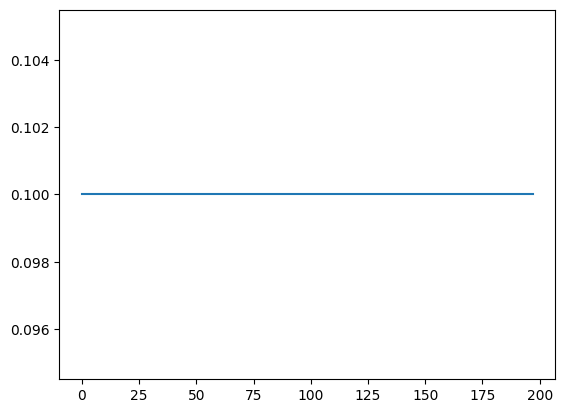

In [5]:
rendering_times = []
for lidar_frame in lidar_data:
    rendering_times.extend(lidar_frame['rendering_time'])
plt.plot(np.diff(rendering_times))

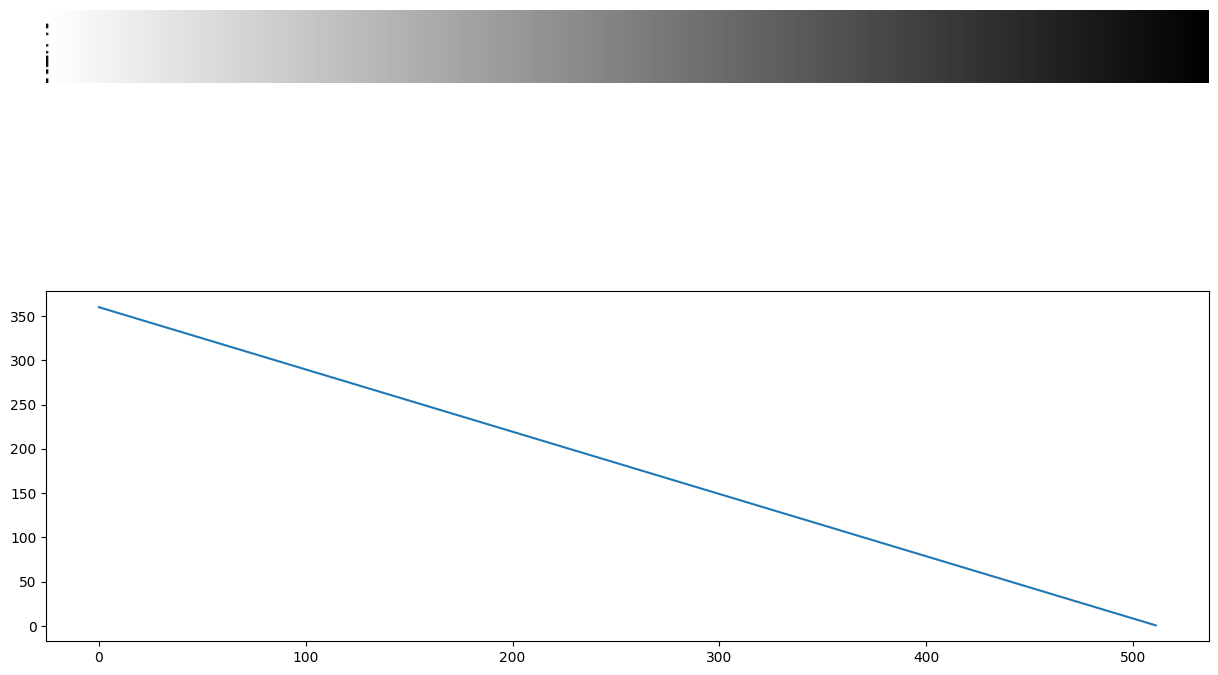

In [6]:
PI=np.pi
azi_offset = np.array([ 4.23, 1.41, -1.4, -4.21, 4.22, 1.42, -1.41, -4.22, 4.23, 1.41, -1.42, -4.21, 4.23, 1.42, -1.4, -4.2, 4.23, 1.41, -1.39, -4.21, 4.25, 1.43, -1.41, -4.22, 4.24, 1.44, -1.41, -4.22, 4.23, 1.42, -1.38, -4.22 ])
azimuths = [d.reshape(-1, 32, 2)[:,:,0].T for d in lidar_data[5]['azimuths']]
tick_azimuths = [a + azi_offset[:,None] for a in azimuths]
tick_azimuths = np.concatenate(tick_azimuths, axis=1)
# tick_azimuths[tick_azimuths<-180] += 360
# tick_azimuths[tick_azimuths>=180] -= 360
tick_azimuths[tick_azimuths<0] += 360


fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].imshow(tick_azimuths, cmap='gray')
axs[0].axis('off')
axs[1].plot(tick_azimuths[0,:])

plt.show()



In [14]:
resume_gui()

gui can be used now. interrupt kernel to go back to notebook


# Undistort point cloud

In [13]:
import noise

PI = np.pi

# make the lidar fly in a circle on xy plane
def make_circular_path(stepsPerSecond, duration, radius, angular_velocity=2*PI):
    t = np.arange(0, duration, 1.0/stepsPerSecond)
    yaw = angular_velocity * t
    pitch = np.zeros_like(yaw)
    roll = np.zeros_like(yaw)
    euler_xyz = np.array([roll, pitch, yaw]).T
    quats = np.array([euler_angles_to_quat(angles, degrees=False, extrinsic=True) for angles in euler_xyz])
    w, i, j, k = quats[:, 0], quats[:, 1], quats[:, 2], quats[:, 3]
    R = radius
    x = R * np.cos(yaw) * np.cos(pitch)
    y = R * np.sin(yaw) * np.cos(pitch)
    z = R * np.sin(pitch)
  
    return np.array([t, x, y, z, w, i, j, k]).T



In [12]:
np.arange(0, 0.5, 1.0/10)

array([0. , 0.1, 0.2, 0.3, 0.4])

In [25]:
path = make_circular_path(10, 0.5, 1, -4*PI)
for p in path:
    print(p[0], p[1:4])

0.0 [ 1. -0.  0.]
0.1 [ 0.30901699 -0.95105652  0.        ]
0.2 [-0.80901699 -0.58778525  0.        ]
0.30000000000000004 [-0.80901699  0.58778525  0.        ]
0.4 [0.30901699 0.95105652 0.        ]


In [20]:
def test():
    stage.create_new_stage()

    steps_per_second = 10
    T = 0.5
    trajectory_radius = 1
    angular_velocity = -4*PI #rad/s, same direction with lidar scan direction
    world = World(1.0/steps_per_second, 1.0/steps_per_second)
    config = "OS1_REV6_32ch10hz512res_noiseless"
    lidar = RtxLidar('/lidar', 'lidar0', position=[0,0,0], config_file_name=config)
    # R = 10
    # sphere = FixedSphere('/TestNoise/Sphere', position=[0, 0, 0])
    # sphere.prim.GetAttribute('xformOp:scale').Set(Gf.Vec3d(R, R, R))
    W, H, D = 20, 20, 10
    cube = FixedCuboid('/TestNoise/Cube', position=[0, 0, 0])
    cube.prim.GetAttribute('xformOp:scale').Set(Gf.Vec3d(W, H, D))

    world.scene.add(lidar)
    # world.scene.add(sphere)
    world.scene.add(cube)
    world.reset(soft=False)
    
    path = make_circular_path(steps_per_second, T, trajectory_radius, angular_velocity)
    print(len(path))
    path_still = np.tile(path[-1], (steps_per_second, 1))
    path = np.concatenate([path, path_still], axis=0)
    print(len(path))
    pi = iter(path)
    running = True
    def set_lidar_pose_cb(event):
        nonlocal running
        try:
            p = next(pi)
            lidar.set_world_pose(p[1:4], p[4:])
        except StopIteration:
            running = False
            

    world.clear_render_callbacks()
    world.add_render_callback('set_lidar_pose', set_lidar_pose_cb)
    
    world.reset(soft=True)
    lidar_data = []
    def buffer_cb(frames):
        lidar_data.append(copy.deepcopy(frames))
    lidar.set_buffering(True, buffer_cb)

    while(running):
        world.step()
    # for _ in range(20):
    #     world.step()
        
    world.stop()
    del lidar # to unsubscribe from event.. manually =.=
    return lidar_data, path

lidar_data, path = test()

skip empty frame
skip empty frame
skip empty frame
skip empty frame
skip empty frame
skip empty frame
5
15
skip empty frame
skip empty frame
skip empty frame


In [22]:
# check transform same or not
for scan in lidar_data:
    time = scan["rendering_time"][0]
    previous_position = scan["transformStart"][0][:3,3]
    current_position = scan["transform"][0][:3,3]
    print(f'lidar cb: time={time}, previous_position={previous_position}, current_position={current_position}')

lidar cb: time=0.20000000298023224, previous_position=[-0. -0. -0.], current_position=[-0. -0. -0.]
lidar cb: time=0.30000000447034836, previous_position=[-0. -0. -0.], current_position=[ 1. -0. -0.]
lidar cb: time=0.4000000059604645, previous_position=[ 1. -0. -0.], current_position=[ 0.309017   -0.95105654 -0.        ]
lidar cb: time=0.5000000074505806, previous_position=[ 0.309017   -0.95105654 -0.        ], current_position=[-0.809017   -0.58778524 -0.        ]
lidar cb: time=0.6000000089406967, previous_position=[-0.809017   -0.58778524 -0.        ], current_position=[-0.809017    0.58778524 -0.        ]
lidar cb: time=0.7000000104308128, previous_position=[-0.809017    0.58778524 -0.        ], current_position=[ 0.309017    0.95105654 -0.        ]
lidar cb: time=0.800000011920929, previous_position=[ 0.309017    0.95105654 -0.        ], current_position=[ 0.309017    0.95105654 -0.        ]
lidar cb: time=0.9000000134110451, previous_position=[ 0.309017    0.95105654 -0.        ]

In [26]:
import rerun as rr
import numpy as np

rr.init("test_distort", spawn=True)

[2024-10-11T09:58:26Z INFO  re_sdk_comms::server] Hosting a SDK server over TCP at 0.0.0.0:9876. Connect with the Rerun logging SDK.
[2024-10-11T09:58:26Z INFO  winit::platform_impl::platform::x11::window] Guessed window scale factor: 1
[2024-10-11T09:58:26Z INFO  re_sdk_comms::server] New SDK client connected from: 127.0.0.1:47668


[2024-10-11T09:58:26Z WARN  wgpu_hal::gles::egl] No config found!
[2024-10-11T09:58:26Z WARN  wgpu_hal::gles::egl] EGL says it can present to the window but not natively
[2024-10-11T09:58:26Z INFO  egui_wgpu] There were 3 available wgpu adapters: {backend: Vulkan, device_type: Cpu, name: "llvmpipe (LLVM 12.0.0, 256 bits)", driver: "llvmpipe", driver_info: "Mesa 21.2.6 (LLVM 12.0.0)", vendor: 0x10005}, {backend: Vulkan, device_type: DiscreteGpu, name: "NVIDIA GeForce RTX 4060", driver: "NVIDIA", driver_info: "555.42.02", vendor: 0x10DE, device: 0x2882}, {backend: Gl, device_type: Other, name: "NVIDIA GeForce RTX 4060/PCIe/SSE2", driver: "OpenGL", driver_info: "4.6.0 NVIDIA 555.42.02", vendor: 0x10DE}


In [27]:

def Axes(l=1.0):
    return rr.Arrows3D(
        vectors=[[l, 0, 0], [0, l, 0], [0, 0, l]],
        colors=[[255,0,0], [0,255,0], [0,0,255]],
    )

def visualize_sim_lidar(groups, name, color=None):
    points = []
    positions = []
    quaternions = []
    
    for i in range(len(groups['rendering_time'])):
        transform = np.array(groups['transform'][i])
        position = transform[:3,3]
        rotation = transform[:3,:3]
        quat = rot_matrix_to_quat(rotation)
        quat_xyzw = np.roll(quat, -1)
        points.append(groups['xyz'][i])
        positions.append(position)
        quaternions.append(quat_xyzw)

    for i in range(len(groups['rendering_time'])):
        rr.log(f'/world/distorted/{name}/{i}', rr.Transform3D(
            translation=positions[i], quaternion=quaternions[i]))
        
        rr.log(f'/world/distorted/{name}/{i}', Axes(1.0))
        rr.log(f'/world/distorted/{name}/{i}/points', rr.Points3D(points[i], colors=color))

rr.set_time_seconds('sim_time', 0)
rr.log('/world', rr.Clear(recursive=True))
rr.log('/world', Axes(0.5), static=True)
trajectory = path[:, 1:4]
rr.log('/world/trajectory', rr.LineStrips3D(trajectory))

for i, scan in enumerate(lidar_data):
    visualize_sim_lidar(scan, f'scan_{i}')

In [37]:
def _to_sensor(pcd, transform):
    return np.matmul(transform[:3, :3].T, (pcd - transform[:3, 3]).T).T

def _linear_interpolate(xp, yp, x):
    if yp.shape[0] != xp.shape[0]:
        raise ValueError("xp and yp must have the same length")
    yp_shape = yp.shape
    yp = yp.reshape(yp_shape[0], -1).T
    y = np.array([np.interp(x, xp, ypi) for ypi in yp]).T
    y = y.reshape(-1, *yp_shape[1:])
    return y

def undistort2(pcd, transforms):
    """
    The Isaac RTX Lidar sensor seems to model the distortion for half of the frame
    So we undistort the first half and use the last transformation for the second half
    If the transformation at the beginning and end of the frame are the same, we skip 
    the interpolation and simply move it to world frame
    Args:
        pcd: point cloud in sensor frame
        transforms: [transformStart, transformEnd] pose of lidar when capture first and last point.
    Return:
        undistorted point cloud in sensor frame (transformEnd)
    """
    if np.allclose(transforms[0], transforms[1]):
        return pcd

    positions = np.array([t[:3, 3] for t in transforms])
    rotations = np.array([t[:3, :3] for t in transforms])
    angles = np.array([matrix_to_euler_angles(r) for r in rotations])
    angles_changes = angles[1] - angles[0]
    for i in range(3):
        if angles_changes[i] > PI:
            angles_changes[i] -= 2*PI
        if angles_changes[i] < -PI:
            angles_changes[i] += 2*PI
        angles[1][i] = angles[0][i] + angles_changes[i]
    pcd1 = pcd[:len(pcd)//2]
    pcd2 = pcd[len(pcd)//2:]
    timestamps = np.array([0, 1])
    times = np.linspace(timestamps[0], timestamps[-1], len(pcd1))

    pos_interpolated = _linear_interpolate(
        timestamps, positions, times)
    angles_interpolated = _linear_interpolate(
        timestamps, angles, times)
    rot_interpolated = np.array([euler_to_rot_matrix(a) for a in angles_interpolated])
    # rot_interpolated = _linear_interpolate(
    #     timestamps, rotations, times)
    pcd1 = np.expand_dims(pcd1, axis=-1)
    pcd1_undistorted = np.squeeze(
        np.matmul(rot_interpolated, pcd1)) + pos_interpolated
    pcd1_undistorted = _to_sensor(pcd1_undistorted, transforms[-1])
    pcd2_undistorted = pcd2
    return np.concatenate([pcd1_undistorted, pcd2_undistorted])


In [39]:
import importlib
import lidar
importlib.reload(lidar)
from lidar import undistort

def Axes(l=1.0):
    return rr.Arrows3D(
        vectors=[[l, 0, 0], [0, l, 0], [0, 0, l]],
        colors=[[255,0,0], [0,255,0], [0,0,255]],
    )

def visualize_sim_lidar_undistort(groups, name, color=None):
    points = []
    positions = []
    quaternions = []

    for i in range(len(groups['rendering_time'])):
        transform = np.array(groups['transform'][i])
        transformStart = np.array(groups['transformStart'][i])
        if np.allclose(transform, transformStart):
            print('same transform!!')
        transforms = [transformStart, transform]
        pcd = groups['xyz'][i]
        pcd_undistort = undistort2(pcd, transforms)
        points.append(pcd_undistort)
        position = transform[:3,3]
        rotation = transform[:3,:3]
        quat = rot_matrix_to_quat(rotation)
        quat_xyzw = np.roll(quat, -1)
        positions.append(position)
        quaternions.append(quat_xyzw)
        
    for i in range(len(groups['rendering_time'])):
        rr.log(f'/world/undistorted/{name}/{i}', rr.Transform3D(
            translation=positions[i], quaternion=quaternions[i]))
        
        rr.log(f'/world/undistorted/{name}/{i}', Axes(1.0))
        rr.log(f'/world/undistorted/{name}/{i}/points', rr.Points3D(points[i], colors=color, radii=0.01))


for i, scan in enumerate(lidar_data):
    visualize_sim_lidar_undistort(scan, f'scan_{i}')

same transform!!
same transform!!
same transform!!
same transform!!
same transform!!
same transform!!
same transform!!
same transform!!
same transform!!
same transform!!


In [19]:
groups = lidar_data[2]
i=0
transform = np.array(groups['transform'][i])
transformStart = np.array(groups['transformStart'][i])
transforms = [transformStart, transform]
pcd = groups['xyz'][i]
pcd_undistort = undistort(pcd, transforms)

In [21]:
groups['rendering_time']

[0.4000000059604645]

In [36]:
lidar_data[2]['transformStart']

[array([[ 1.,  0.,  0.,  1.],
        [ 0.,  1.,  0., -0.],
        [ 0.,  0.,  1., -0.],
        [ 0.,  0.,  0.,  1.]])]

# Optimize the rendering time
- First set dt to a very small value. Check how long it take to simulate 1 second.
- Then disable the viewport and run again.

In [ ]:
stage.create_new_stage()

ticksPerSecond = lidar_info['ticksPerScan'] * 10 # =.=!
simulation_context = SimulationContext(
  physics_dt=1.0/ticksPerSecond,
  rendering_dt=1.0/ticksPerSecond
)

lidar = RtxLidarFullFrame("/TestNoise/Lidar", position=[0,0,0], config_file_name="OS1_REV6_32ch10hz512res")
wall = FixedSphere('/TestNoise/Sphere', position=[0, 0, 0])
wall.prim.CreateAttribute('refinementEnableOverride', Sdf.ValueTypeNames.Bool).Set(True)
wall.prim.CreateAttribute('refinementLevel', Sdf.ValueTypeNames.Int).Set(5)

simulation_context.play()
for _ in range(ticksPerSecond):
  simulation_context.step()
simulation_context.stop()
  

In [ ]:
#changing the dt seems to reset things inside. So create the lidar again
stage.create_new_stage()

scansPerSecond = 10 # =.=!
ticksPerSecond = lidar_info['ticksPerScan'] * scansPerSecond
simulation_context = SimulationContext(
  physics_dt=1.0/ticksPerSecond,
  rendering_dt=1.0/ticksPerSecond
)

lidar = RtxLidarFullFrame("/TestNoise/Lidar", position=[0,0,0], config_file_name="OS1_REV6_32ch10hz512res")
wall = FixedSphere('/TestNoise/Sphere', position=[0, 0, 0])
wall.prim.CreateAttribute('refinementEnableOverride', Sdf.ValueTypeNames.Bool).Set(True)
wall.prim.CreateAttribute('refinementLevel', Sdf.ValueTypeNames.Int).Set(5)

# set the viewport to the lidar camera, so that it render nothing. Is there any other way?
vp_window = get_window_from_id('Viewport/Viewport0')
omni.kit.commands.execute(
    "SetViewportCamera", camera_path='/TestNoise/Lidar', viewport_api=vp_window.viewport_api
)

lidar_rotate_dt = 1.0 / scansPerSecond
next_lidar_ready = lidar_rotate_dt

simulation_context.play()
data = []
for _ in range(ticksPerSecond):
  simulation_context.step()
  timestamp = simulation_context.current_time
  if timestamp > next_lidar_ready:
    data.append(deep_copy(lidar.get_current_frame()))
    next_lidar_ready += lidar_rotate_dt
    
simulation_context.stop()

### disable viewport rendering reduce runtime from 103s to 71s (~30%)